In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib
import os

In [2]:
print(sns.__version__)

0.9.0


In [3]:
lon = {'Californian':[-155,-95], 'Peruvian':[-115,-55], 'Namibian':[-25,35]}
lat = {'Californian':[5,55], 'Peruvian':[-45,5], 'Namibian':[-45,15]}
name_convert = {'Peru':'Peruvian', 'California':'Californian', 'Namibia':'Namibian'}

to_plot_1km = ['Cloud_Effective_Radius', 'Cloud_Water_Path', 'Cloud_Optical_Thickness']
# to_plot_5km = ['Surface_Pressure', 'Cloud_Top_Height', 'Cloud_Fraction', 'Tropopause_Height', 'Surface_Temperature']
to_plot_5km = ['Cloud_Top_Height', 'Cloud_Fraction', 'Surface_Temperature']

formatted_names = {'Cloud_Effective_Radius':'Cloud Effective Radius ($\mu$m)', 'Cloud_Water_Path':'Cloud Water Path (g/m^2)', 'Cloud_Optical_Thickness':'Cloud Optical Thickness (1)', 'Surface_Pressure':'Surface Pressure (hPa)', 'Cloud_Top_Height':'Cloud Top Height (m)', 'Cloud_Fraction':'Cloud Fraction (1)', 'Tropopause_Height':'Tropopause Height (hPa)', 'Surface_Temperature':'Surface Temperature (K)'}

In [4]:

def load_poc_database(filename):
    from sklearn.externals import joblib
    poc_database = joblib.load(filename)
    indices = []
    filename_index = 0
    filenames = {}
    filenames_list = []
    for filename, value in poc_database.items():
        filenames[filename] = filename_index
        filenames_list.append(filename)
        for poc in range(value['poc_no']):
            indices.append((filename_index,poc))
        filename_index += 1

    index = pd.MultiIndex.from_tuples(indices, names=['Image', 'POC'])
    # columns = ['Poc Score', 'Area', 'Perimeter', 'Region']
    columns = {'float32': 'Poc Score', 'float32':'Area', 'float32':'Perimeter', "string":'Region'}
    poc_data = pd.DataFrame(index=index, columns=columns)

    regions = ['California', "Namibia", "Peru"]

    def get_region(f):

        for region in regions:
            if region.lower() in f:
                return region
        print(f)
        raise ValueError("Unkown region")

    for filename, value in poc_database.items():
        for poc in range(value['poc_no']):
            poc_data.at[(filenames[filename], poc), 'Poc Score'] = value['poc_data'][poc]['poc_score']
            poc_data.at[(filenames[filename], poc), 'Area'] = value['poc_data'][poc]['area']
            poc_data.at[(filenames[filename], poc), 'Perimeter'] = value['poc_data'][poc]['perimeter']
            poc_data.at[(filenames[filename], poc), 'Region'] = get_region(filename)
    return poc_data

poc_data = load_poc_database('/Users/watson-parris/Local Data/POC_data/POC_database_2.dat')

/Users/watson-parris/miniconda3/envs/xarray/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
def assign_place(poc_df):
    res = []
    # We only need to test one of the slices of the POC
    single_slice_of_poc = poc_df.iloc[0]
    for place, value in lon.items():
        if single_slice_of_poc.latitude > lat[place][0] and single_slice_of_poc.latitude < lat[place][1] and \
          single_slice_of_poc.longitude >lon[place][0] and single_slice_of_poc.longitude < lon[place][1]:
            res.append(place)
    # Check we matched exactly one place
    assert len(res) == 1, 'summin went wrong ere!'
    return res[0]

def get_combined_df(pickle_file, pixel_size, stripe_width):
    """
    
    pixel_size # 1 for 1km, 5 for 5km
    stripe_width # Number of pixels each stripe represents
    
    """
    csv_file = pickle_file + '.csv'
    if os.path.isfile(csv_file):
        return pd.read_csv(csv_file)
    else:
        with open(pickle_file, 'rb') as handle:
            data = pickle.load(handle)

    # print(data[6])
    POCs = [len(d['latitude']) for d in data if d is not None]
    n_POCs = sum(POCs)
    print("Number of POCs found: {}".format(n_POCs))

    n_stripes = len(data[6]['latitude'][0])  # No. of stripes (assuming all the same)

    n_stripes_from_boundary = (math.ceil(n_stripes/2)-0.5)

    # Combine all the dictionaries into one with stacked arrays
    pandas_data = {}
    for key, value in data[6].items():
        pandas_data[key] = np.zeros((0, n_stripes))

    for image in data:
        if image: 
            for variable, array in image.items():
                pandas_data[variable] = np.append(pandas_data[variable], np.asarray(array), axis=0)
                pandas_data[variable] = pd.DataFrame(pandas_data[variable])

    pandas_long_form = pd.DataFrame()
    for variable, array in pandas_data.items():
        pandas_long_form[variable] = array.stack()

    pandas_long_form['Distance from Boundary (km)'] = (pandas_long_form.index.get_level_values(1).values-n_stripes_from_boundary)*pixel_size*stripe_width
    
    # Group by POC, apply the assignment function, then reindex to broadcast across the slices
    pandas_long_form['Location'] = pandas_long_form.groupby(level=0, axis=0).apply(assign_place).reindex(pandas_long_form.index, level=0)
    
#   # Save the df for next time
    pandas_long_form.to_csv(csv_file)
    return pandas_long_form

In [6]:
df_1km = get_combined_df('results/results_1km.pickle', pixel_size=1, stripe_width=15)
df_5km = get_combined_df('results/results_5km.pickle', pixel_size=5, stripe_width=3)

Number of POCs found: 3747
Number of POCs found: 3721


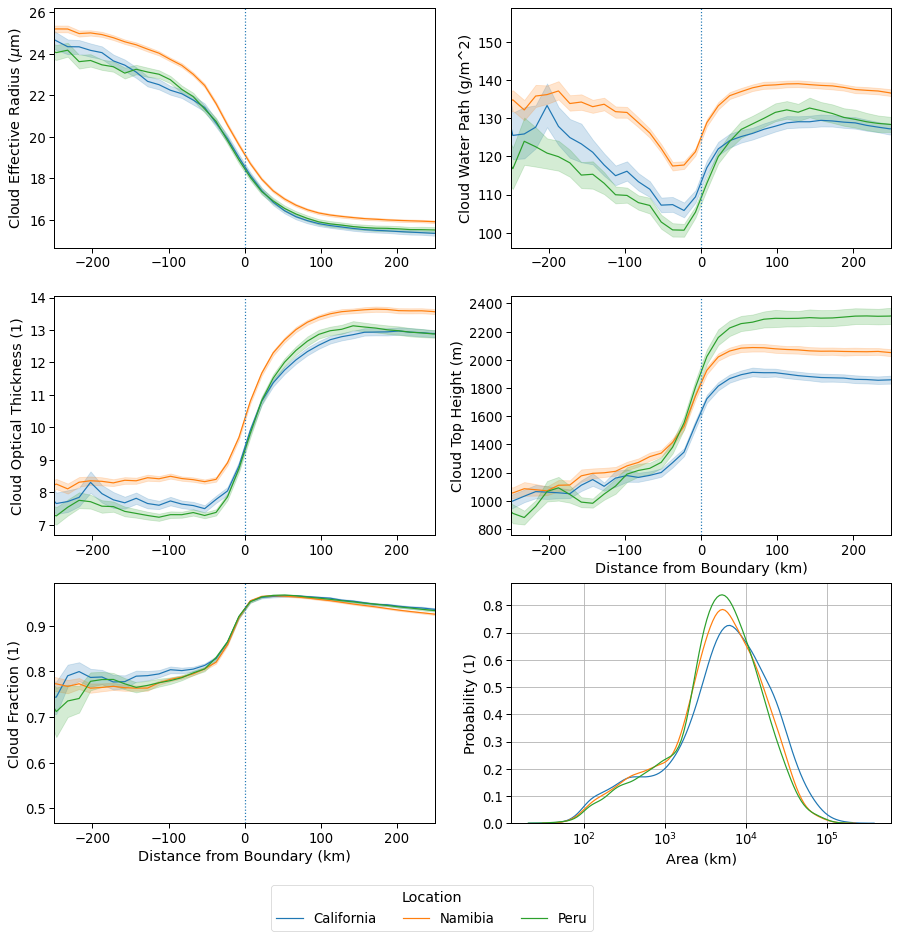

In [7]:
no_variables=len(to_plot_1km+to_plot_5km)

sns.set_context('paper', font_scale=1.5)

index = 0
fig, ax = plt.subplots(math.floor(no_variables/2), 2, figsize = (15, 5*math.floor(no_variables/2)))

for variable in to_plot_1km:
    current_ax=ax[math.floor(index/2),index%2]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_1km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2):
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1

for variable in to_plot_5km[:-1]:
    current_ax=ax[math.floor(index/2),index%2]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_5km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2)-1:
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1
    
ax[2,0].set_xlabel('Distance from Boundary (km)')
    
# Plot the area distribution
area_ax = ax[2,1]
for r in name_convert.keys():
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=False, clip=[1,6], ax=area_ax)

area_ax.grid()
area_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
area_ax.set_xlabel("Area (km)")
area_ax.set_ylabel("Probability (1)")

    
fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01))
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)

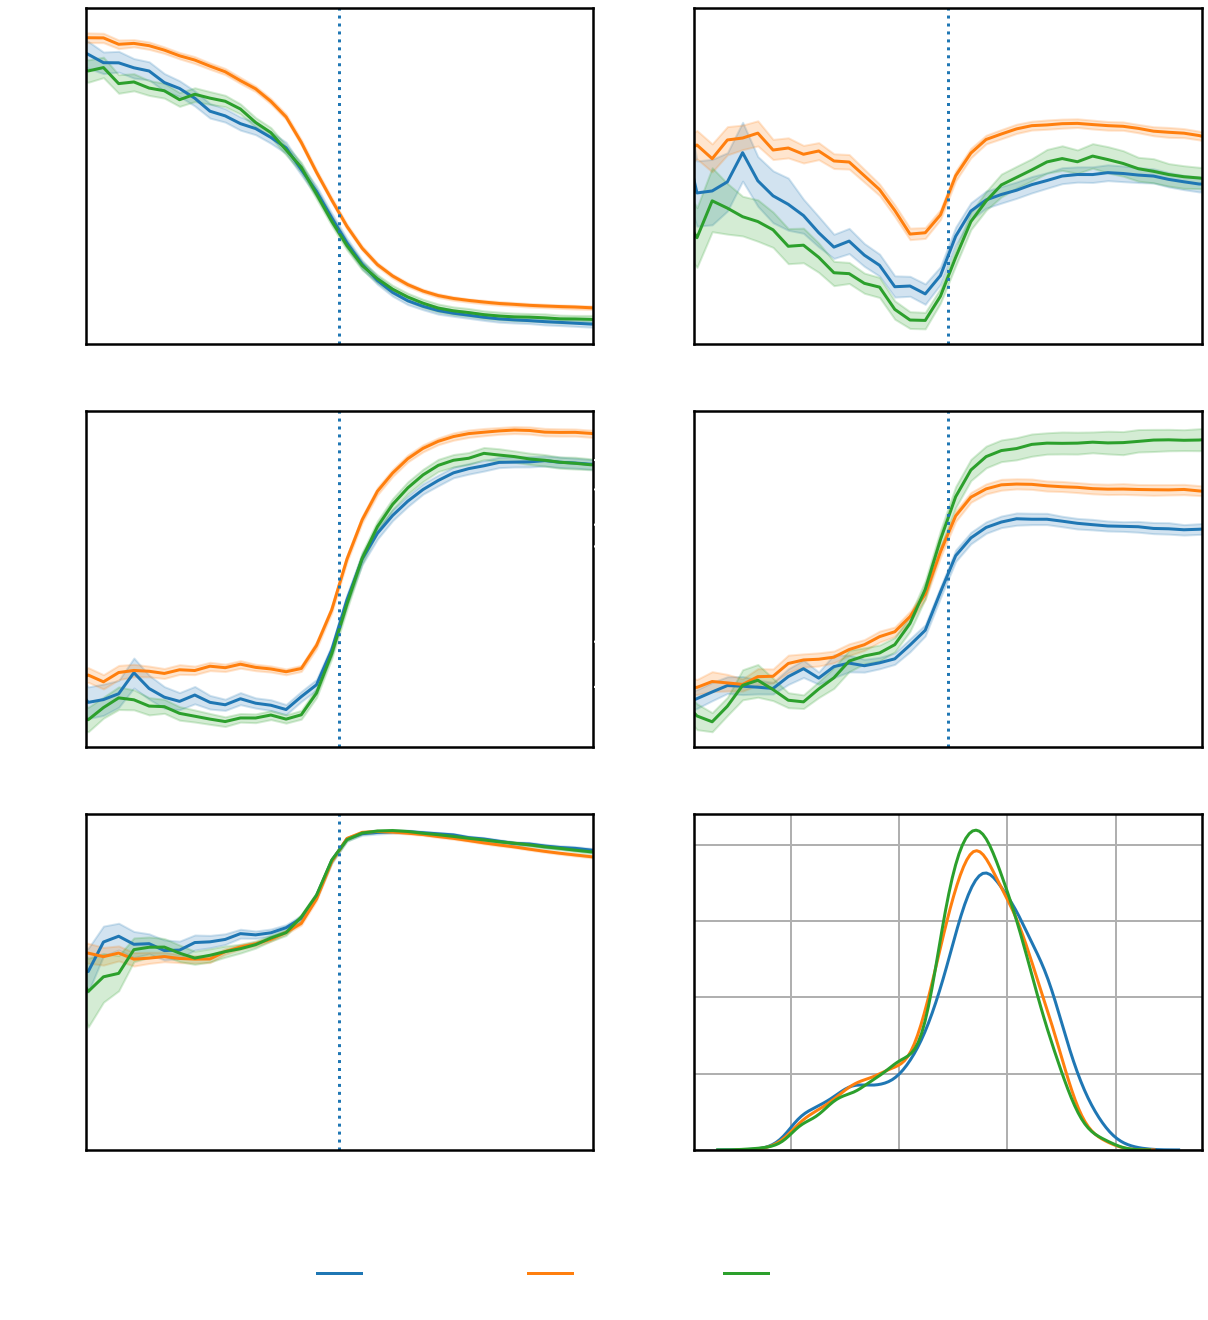

In [8]:
no_variables=len(to_plot_1km+to_plot_5km)

sns.set_context('poster')
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

index = 0
fig, ax = plt.subplots(math.floor(no_variables/2), 2, figsize = (20, 7*math.floor(no_variables/2)))

for variable in to_plot_1km:
    current_ax=ax[math.floor(index/2),index%2]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_1km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2):
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1

for variable in to_plot_5km[:-1]:
    current_ax=ax[math.floor(index/2),index%2]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_5km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2):
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1
    
ax[2,0].set_xlabel('Distance from Boundary (km)')
    
# Plot the area distribution
area_ax = ax[2,1]
for r in name_convert.keys():
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=False, clip=[1,6], ax=area_ax)
    
area_ax.grid()
area_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
area_ax.set_xlabel("Area (km)")
area_ax.set_ylabel("Probability (1)")
    
fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01), framealpha=0.)
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)
plt.savefig('POC_properties_POSTER.png', transparent=True)

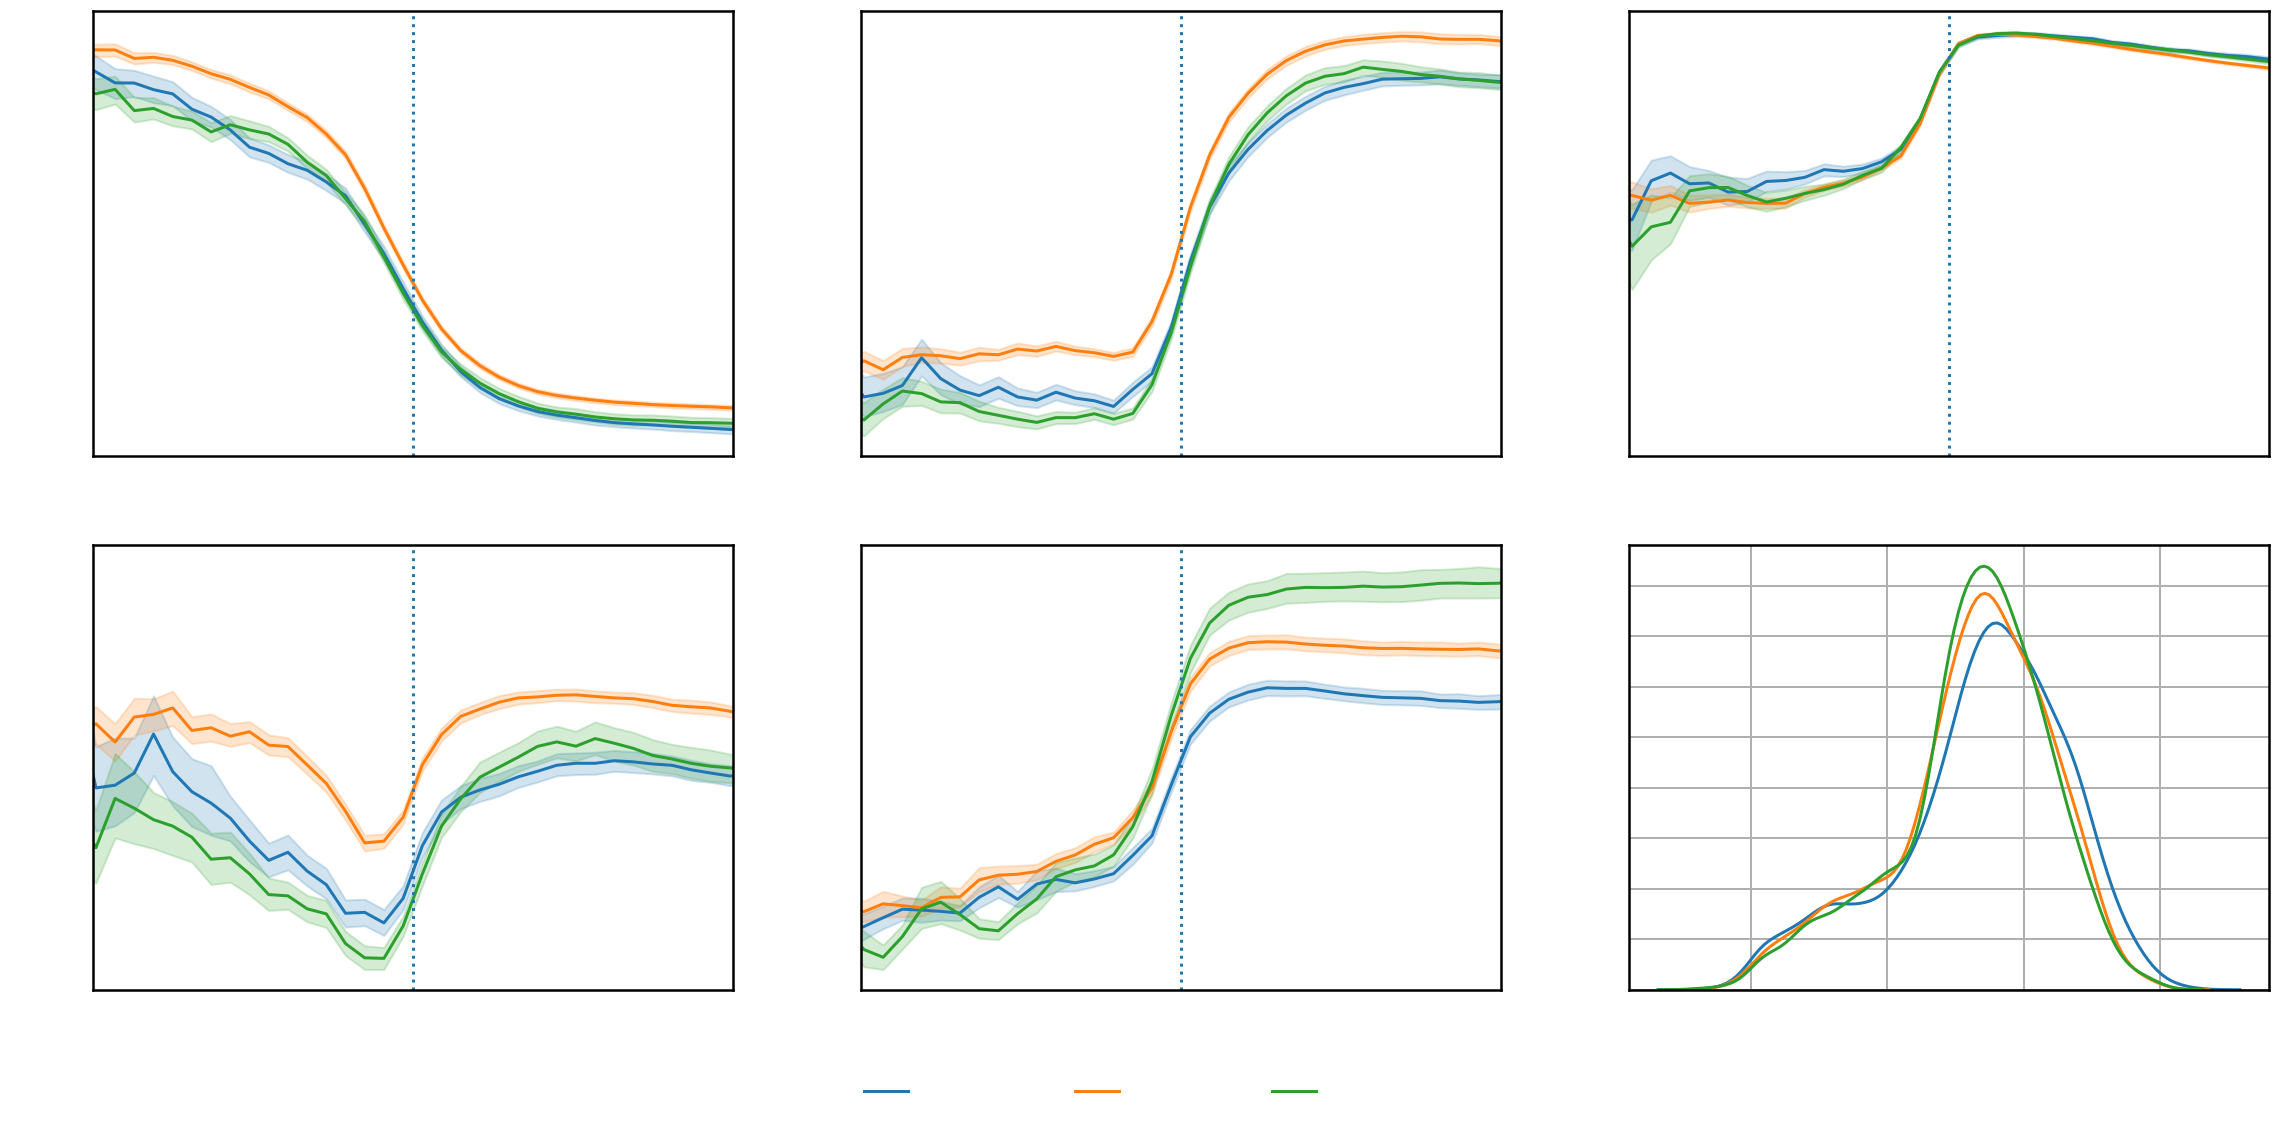

In [9]:
no_variables=len(to_plot_1km+to_plot_5km)

sns.set_context('poster')
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['font.size'] = 20

index = 0
fig, ax = plt.subplots(2, math.floor(no_variables/2), figsize = (13*math.floor(no_variables/2), 18))

for variable in to_plot_1km:
    current_ax=ax[index%2, math.floor(index/2)]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_1km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2):
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1

for variable in to_plot_5km[:-1]:
    current_ax=ax[index%2, math.floor(index/2)]
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_5km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    if math.ceil((index+1)/2) != math.floor(no_variables/2):
        current_ax.set_xlabel('')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    handles, labels = current_ax.get_legend_handles_labels()
    current_ax.get_legend().remove()
    index += 1
    
ax[0,2].set_xlabel('Distance from Boundary (km)')
    
# Plot the area distribution
area_ax = ax[1,2]
for r in name_convert.keys():
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=False, clip=[1,6], ax=area_ax)
    
area_ax.grid()
area_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
area_ax.set_xlabel("Area (km)")
area_ax.set_ylabel("Probability (1)")
    
fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01), framealpha=0.)
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)
plt.savefig('POC_properties_POSTER_horizontal.png', transparent=True)

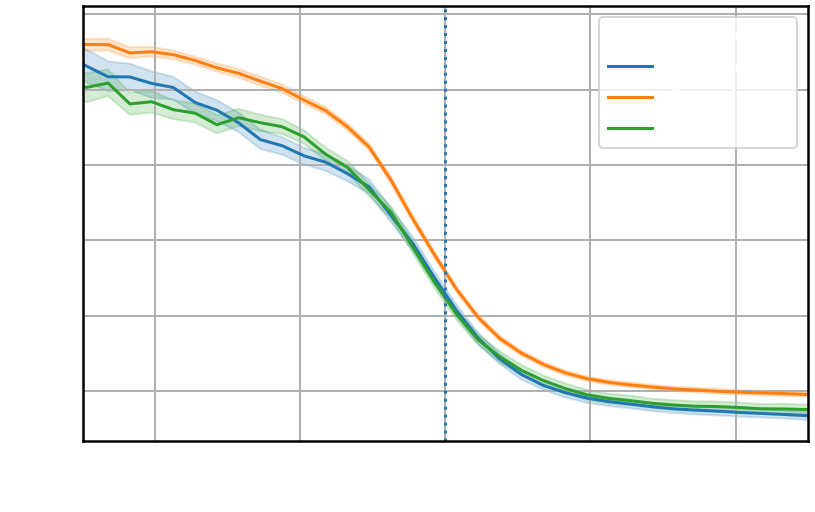

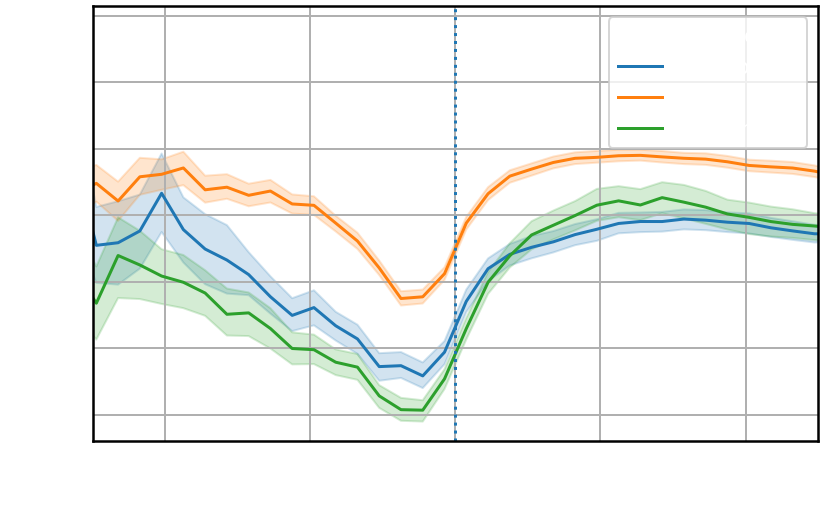

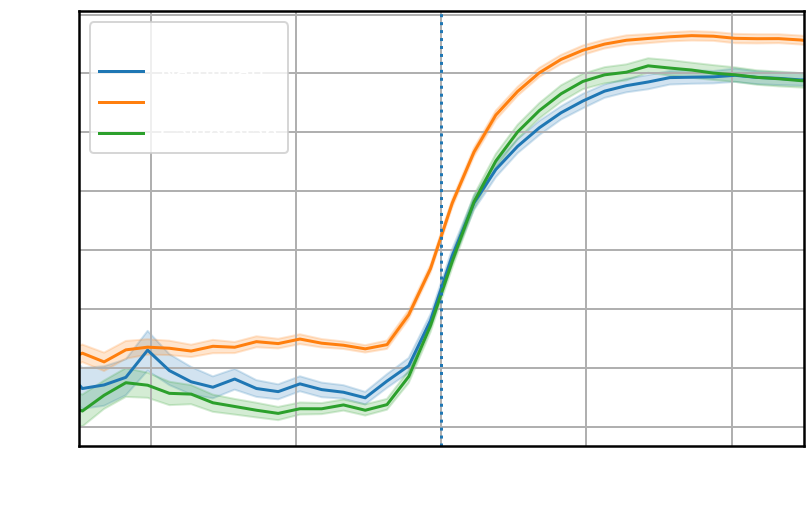

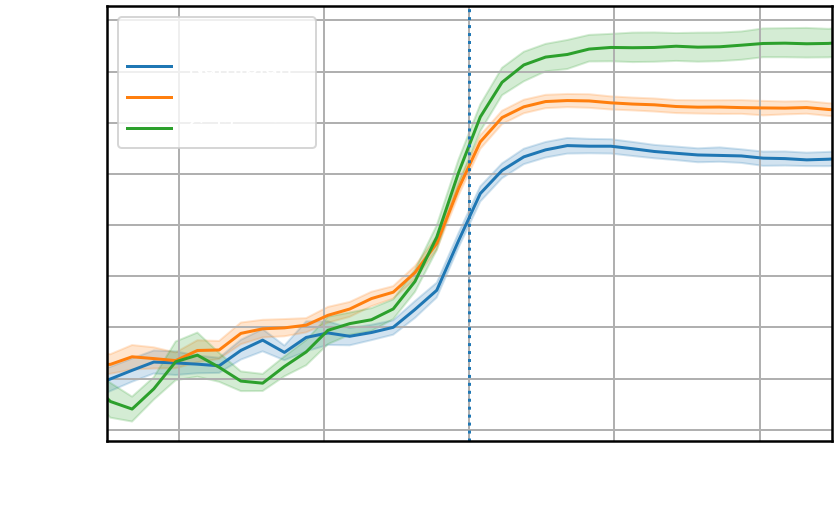

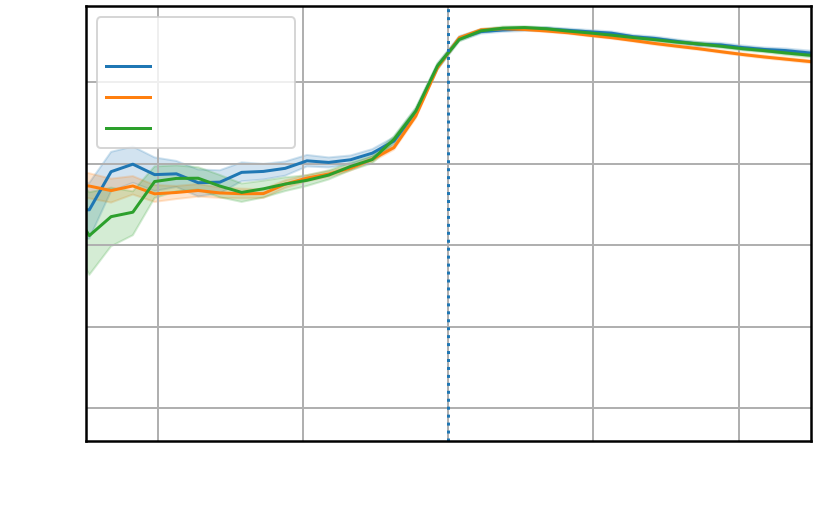

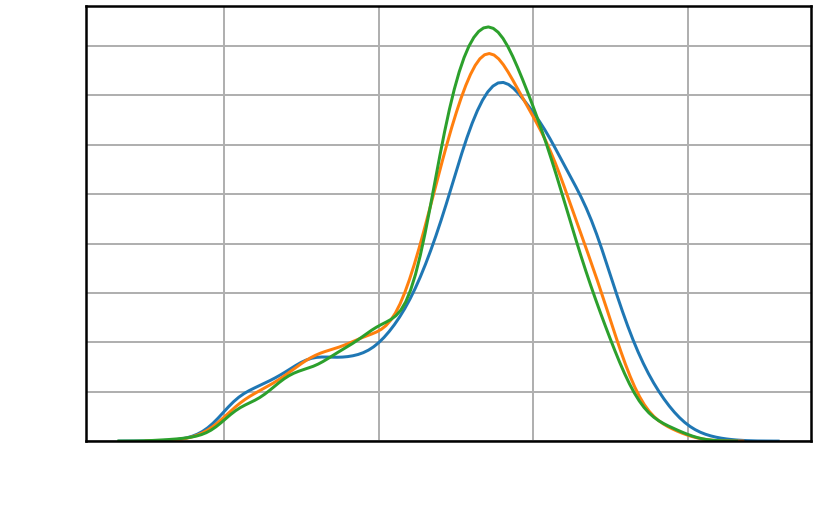

In [12]:
no_variables=len(to_plot_1km+to_plot_5km)

sns.set_context('poster')
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['font.size'] = 20

index = 0

for variable in to_plot_1km:
    fig, current_ax = plt.subplots(figsize = (13, 8))
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_1km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    current_ax.grid()
#     handles, labels = current_ax.get_legend_handles_labels()
#     current_ax.get_legend().remove()
    index += 1
    plt.savefig('POC_properties_TALK_{}.png'.format(variable), transparent=True)
    plt.show()

for variable in to_plot_5km[:-1]:
    fig, current_ax = plt.subplots(figsize = (13, 8))
    sns.lineplot(x='Distance from Boundary (km)', y=variable, data=df_5km, hue='Location', ax=current_ax, ci=68)
    current_ax.axvline(x=0, linestyle=':')
    current_ax.set_ylabel(formatted_names[variable])
    current_ax.set_xlim(-250,250)
    current_ax.grid()
#     handles, labels = current_ax.get_legend_handles_labels()
#     current_ax.get_legend().remove()
    plt.savefig('POC_properties_TALK_{}.png'.format(variable), transparent=True)
    plt.show()
    
    
# Plot the area distribution
fig, current_ax = plt.subplots(figsize = (13, 8))
for r in name_convert.keys():
    hist = sns.kdeplot(np.log10(poc_data[poc_data.Region==r]['Area']), legend=False, clip=[1,6], ax=current_ax)
    
current_ax.grid()
current_ax.set_xticklabels([f"$10^{int(t)}$" for t in area_ax.get_xticks()])
current_ax.set_xlabel("Area (km)")
current_ax.set_ylabel("Probability (1)")
    
# fig.legend(handles[1:], ['California', 'Namibia', 'Peru'], ncol=3, title='Location', loc='lower center', bbox_to_anchor=(0.4, 0.01), framealpha=0.)
# fig.tight_layout()
# fig.suptitle('Properties of POCs', fontsize=22)
plt.savefig('POC_properties_TALK_area.png', transparent=True)

In [ ]:
df_1km.xs(20, level=1)

In [ ]:
# help(sns.distplot)
sns.distplot(df_1km.xs(10, level=1).Cloud_Water_Path[~df_1km.xs(10, level=1).Cloud_Water_Path.isna()], label='POC')
sns.distplot(df_1km.xs(18, level=1).Cloud_Water_Path[~df_1km.xs(18, level=1).Cloud_Water_Path.isna()], label='Transition')
sns.distplot(df_1km.xs(30, level=1).Cloud_Water_Path[~df_1km.xs(30, level=1).Cloud_Water_Path.isna()], label='Overcast')
plt.xlim(0, 400)
plt.legend()

In [ ]:
# help(sns.distplot)
sns.distplot(df_1km.xs(10, level=1).Cloud_Effective_Radius[~df_1km.xs(10, level=1).Cloud_Effective_Radius.isna()], label='POC')
sns.distplot(df_1km.xs(18, level=1).Cloud_Effective_Radius[~df_1km.xs(18, level=1).Cloud_Effective_Radius.isna()], label='Transition')
sns.distplot(df_1km.xs(30, level=1).Cloud_Effective_Radius[~df_1km.xs(30, level=1).Cloud_Effective_Radius.isna()], label='Overcast')
plt.xlim(0, 40)
plt.legend()

In [ ]:
# help(sns.distplot)
sns.distplot(df_1km.xs(10, level=1).Cloud_Optical_Thickness[~df_1km.xs(10, level=1).Cloud_Optical_Thickness.isna()], label='POC')
sns.distplot(df_1km.xs(18, level=1).Cloud_Optical_Thickness[~df_1km.xs(18, level=1).Cloud_Optical_Thickness.isna()], label='Transition')
sns.distplot(df_1km.xs(30, level=1).Cloud_Optical_Thickness[~df_1km.xs(30, level=1).Cloud_Optical_Thickness.isna()], label='Overcast')
plt.xlim(0, 40)
plt.legend()

In [ ]:
# help(sns.distplot)
sns.distplot(df_5km.xs(10, level=1).Cloud_Top_Height[~df_5km.xs(10, level=1).Cloud_Top_Height.isna()], label='POC')
sns.distplot(df_5km.xs(18, level=1).Cloud_Top_Height[~df_5km.xs(18, level=1).Cloud_Top_Height.isna()], label='Transition')
sns.distplot(df_5km.xs(30, level=1).Cloud_Top_Height[~df_5km.xs(30, level=1).Cloud_Top_Height.isna()], label='Overcast')
plt.xlim(0, 4000)
plt.legend()